# Calculating the diffraction patterns of cities

In [32]:
from PIL import Image
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import csv

First we load an image of a city map using the PIL library and convert it to grayscale, then plot it.

[This site](https://anvaka.github.io/city-roads/?q=chicago&areaId=3600122604) is a good source of clear maps but any image that clearly shows the road structure should do.

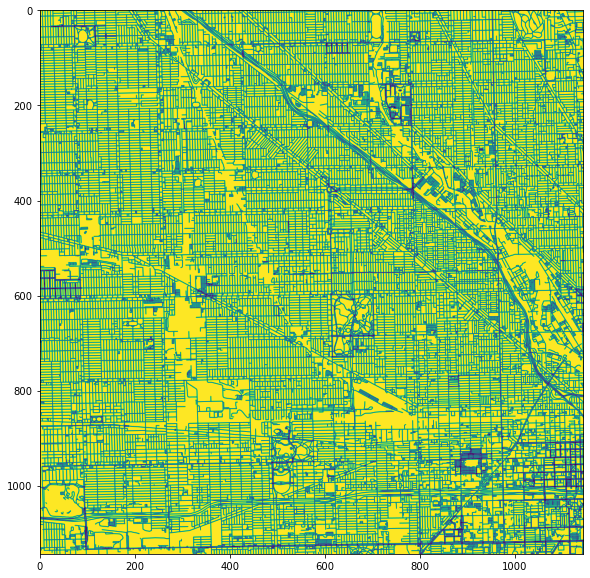

In [2]:
filename = "Chicago.png"
image = Image.open(filename)
image = image.convert('L')

fig = plt.figure(facecolor='w', figsize=(10,10))
plt.imshow(image)
plt.show()

Now we convert the image to a numpy array and calculate the Fourier transform using numpy's fft.fft2() method.

fftshift() is used to center the image in the Fourier domain.

As the fourier transform outputs a complex number, we use the absolute value of the result to get a magnitude we can plot.

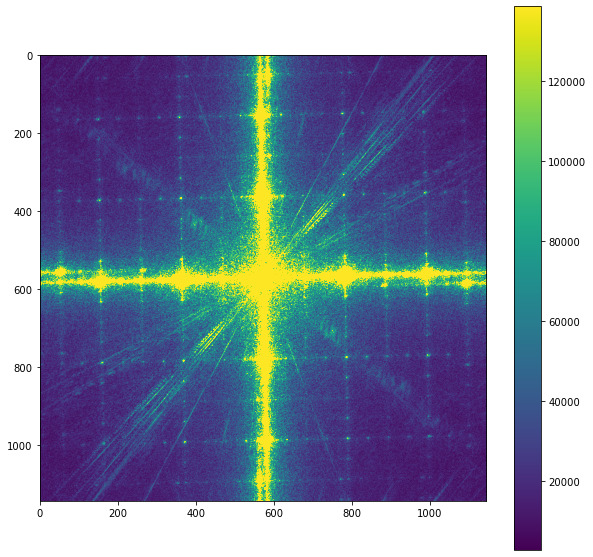

In [27]:
image = np.array(image)
im_fft = np.fft.fft2(image)
im_fft = np.fft.fftshift(im_fft)
im_fft = np.abs(im_fft)

fig = plt.figure(facecolor='w', figsize=(10,10))

# Use quantiles to cut off extremes of the color scale
vmin = np.quantile(im_fft, 0.01)
vmax = np.quantile(im_fft, 0.95)

plt.imshow(im_fft, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.show()

If you have ever performed single-crystal diffraction, this image might see familiar - this is an image in reciprocal space. Single points correspond to distinct periodicity in both dimensions (in crystallography, these would be hkl reflections - here, they would be hk - no third dimension). This arises the the majority of blocks being around the same size with an aspect ratio of 4:1.

The lines between points are what might be called diffuse scattering - they correspond to disorder in one direction, but periodicity in the other. Here, this arises from the presence of blocks of different sizes, which are nevertheless still oriented in the orthogonal grid as the rest of the city.

To obatain a 'powder diffraction pattern', we simply take the radial integration of the Fourier transformed image.
The radial integration code below comes from [here](https://levelup.gitconnected.com/a-simple-method-to-calculate-circular-intensity-averages-in-images-4186a685af3#).

In [28]:
img = im_fft
# Image center
cen_x = im_fft.shape[0]//2
cen_y = cen_x
# Get image parameters
a = img.shape[0]
b = img.shape[1]
# Find radial distances
[X, Y] = np.meshgrid(np.arange(b) - cen_x, np.arange(a) - cen_y)
R = np.sqrt(np.square(X) + np.square(Y))
rad = np.arange(1, np.max(R), 1)
intensity = np.zeros(len(rad))
index = 0

# Edit this depending on the resolution of the image
bin_size = 3

for i in rad:
    mask = (np.greater(R, i - bin_size) & np.less(R, i + bin_size))
    values = img[mask]
    intensity[index] = np.mean(values)
    index += 1

Now we plot the diffraction pattern.

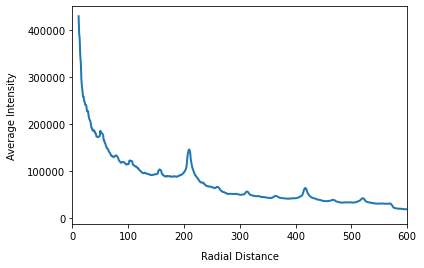

In [31]:
# Create figure and add subplot
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)

# Plot data
x_cutoff = 10
ax.plot(rad[x_cutoff:], intensity[x_cutoff:], linewidth=2)

# Edit axis labels
ax.set_xlabel('Radial Distance', labelpad=10)
ax.set_ylabel('Average Intensity', labelpad=10)
ax.set_xlim(0,600)
# ax.set_ylim(0,0.07e6)
plt.show()

We can now save the file as a 2 column .xy file to perform a refinement in a different program.

In [35]:
# Generate the x values
x = np.arange(0, 90, 90/(len(intensity)))

data = zip(x[cutoff:], intensity[cutoff:])
data = list(data)

# write an xy file
filename = filename.split('.')[0]
with open(f'{filename}.xy', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ')
    writer.writerows(data)